## Notebook to analyse manual lesion masks

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
import meld_graph.experiment
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import ptitprince as pt
import seaborn as sns

Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350
Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data


# Get lesion masks

In [4]:
def cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0):
        """cluster predictions and threshold based on min_area_threshold

        Args:
            mask: boolean mask of the per-vertex lesion predictions to cluster"""
        n_comp, labels = scipy.sparse.csgraph.connected_components(cohort.adj_mat[mask][:, mask])
        islands = np.zeros(len(mask))
        # only include islands larger than minimum size.
        for island_index in np.arange(n_comp):
            include_vec = labels == island_index
            size = np.sum(include_vec)
            if size >= min_area_threshold:
                island_count += 1
                island_mask = mask.copy()
                island_mask[mask] = include_vec
                islands[island_mask] = island_count
        return islands

In [5]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5', 
                    dataset='MELD_dataset_V6.csv')

patients = cohort.get_subject_ids(group='patient', lesional_only=True )

print(len(patients))


538


In [13]:
subject_ids, trainval_ids, test_ids = cohort.read_subject_ids_from_dataset()

In [15]:
trainval_ids

['MELD2_H7_3T_FCD_003',
 'MELD2_H7_3T_FCD_006',
 'MELD2_H7_3T_FCD_007',
 'MELD2_H7_3T_FCD_008',
 'MELD2_H7_3T_FCD_010',
 'MELD2_H7_3T_FCD_012',
 'MELD2_H7_3T_FCD_013',
 'MELD_H10_3T_C_0002',
 'MELD_H10_3T_C_0003',
 'MELD_H10_3T_C_0004',
 'MELD_H10_3T_C_0007',
 'MELD_H10_3T_C_0008',
 'MELD_H10_3T_C_0010',
 'MELD_H10_3T_C_0016',
 'MELD_H10_3T_C_0020',
 'MELD_H10_3T_C_0023',
 'MELD_H10_3T_C_0024',
 'MELD_H10_3T_C_0026',
 'MELD_H10_3T_C_0027',
 'MELD_H10_3T_C_0030',
 'MELD_H10_3T_C_0032',
 'MELD_H10_3T_FCD_0001',
 'MELD_H10_3T_FCD_0003',
 'MELD_H10_3T_FCD_0004',
 'MELD_H10_3T_FCD_0005',
 'MELD_H10_3T_FCD_0006',
 'MELD_H10_3T_FCD_0007',
 'MELD_H10_3T_FCD_0010',
 'MELD_H10_3T_FCD_0011',
 'MELD_H10_3T_FCD_0015',
 'MELD_H11_3T_FCD_0004',
 'MELD_H11_3T_FCD_0005',
 'MELD_H11_3T_FCD_0013',
 'MELD_H11_3T_FCD_0016',
 'MELD_H11_3T_FCD_0017',
 'MELD_H11_3T_FCD_0021',
 'MELD_H11_3T_FCD_0022',
 'MELD_H11_3T_FCD_0023',
 'MELD_H11_3T_FCD_0024',
 'MELD_H11_3T_FCD_0026',
 'MELD_H11_3T_FCD_0029',
 'MELD_H11

In [17]:
df = pd.DataFrame()

for subject in patients:
    values = {}
    values['ID'] = subject
    subj = MeldSubject(subject, cohort)
    
    # find dataset split
    if subject in test_ids:
        values['dataset'] = 'test'
    elif subject in trainval_ids:
        values['dataset'] = 'train'
    else:
        print('Cannot find split')
    # add info about MRI status
    values['MRI-negative'] = subj.get_demographic_features('Ever reported MRI negative')
    
    # get lesional hemisphere
    hemi = subj.get_lesion_hemisphere()
    values['hemi'] = hemi
    
    # load lesion
    labels = subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:]
        
    # get lesion size
    mask = (labels>0).astype(bool)
    values['lesion_size'] = mask.sum()
        
    # cluster lesion
    labels_clust = cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0)
    values['n_cluster'] = len(set(labels_clust))-1
    
    for cl in set(labels_clust):
        if cl !=0:
            size_cl = (labels_clust==cl).sum()
            values[f'size_cluster_{cl}'] = size_cl
        
    
    # add info into dataframe
    df = pd.concat([df, pd.DataFrame([values])])
    
    

In [19]:
df.head()

,ID,dataset,MRI-negative,hemi,lesion_size,n_cluster,size_cluster_1.0,size_cluster_2.0,size_cluster_3.0,size_cluster_4.0,size_cluster_5.0,size_cluster_6.0,size_cluster_7.0,size_cluster_8.0,size_cluster_9.0,size_cluster_10.0
0,MELD_H12_3T_FCD_0001,train,1.0,rh,1411,1,1411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0002,train,1.0,lh,1131,1,1131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0003,test,0.0,lh,3861,2,3859,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0004,train,1.0,lh,2293,1,2293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H12_3T_FCD_0005,train,1.0,rh,27595,2,27592,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
subdf = df[(df['dataset']=='test')&(df['n_cluster']>1)&(df['size_cluster_2.0']>100)]
subdf

,ID,dataset,MRI-negative,hemi,lesion_size,n_cluster,size_cluster_1.0,size_cluster_2.0,size_cluster_3.0,size_cluster_4.0,size_cluster_5.0,size_cluster_6.0,size_cluster_7.0,size_cluster_8.0,size_cluster_9.0,size_cluster_10.0
0,MELD_H4_3T_FCD_0038,test,0.0,lh,5250,2,5105,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H24_3T_FCD_0003,test,0.0,lh,1307,2,37,1270.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H2_15T_FCD_0003,test,0.0,rh,3900,10,2736,212.0,831.0,112.0,3.0,2.0,1.0,1.0,1.0,1.0
0,MELD_H2_15T_FCD_0028,test,0.0,rh,2746,4,2225,491.0,29.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H2_15T_FCD_0030,test,0.0,lh,991,4,318,671.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H6_3T_FCD_0017,test,0.0,lh,1205,8,764,226.0,161.0,41.0,1.0,10.0,1.0,1.0,NaN,NaN
0,MELD_H23_15T_FCD_0015,test,0.0,rh,4364,7,3767,312.0,8.0,211.0,64.0,1.0,1.0,NaN,NaN,NaN
0,MELD_H23_15T_FCD_0032,test,0.0,rh,3158,3,2388,720.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,MELD_H21_15T_FCD_0038,test,0.0,lh,51174,5,50305,816.0,21.0,31.0,1.0,NaN,NaN,NaN,NaN,NaN
0,MELD_H21_3T_FCD_0007,test,0.0,rh,874,2,614,260.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
import shutil
folder = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all/results_best_model/images'
# os.mkdir(os.path.join(folder,'subfolder'),)
for subject in subdf['ID']:
    shutil.copy(os.path.join(folder,subject+'.jpg'), os.path.join(folder,'subfolder',subject+'.jpg'))

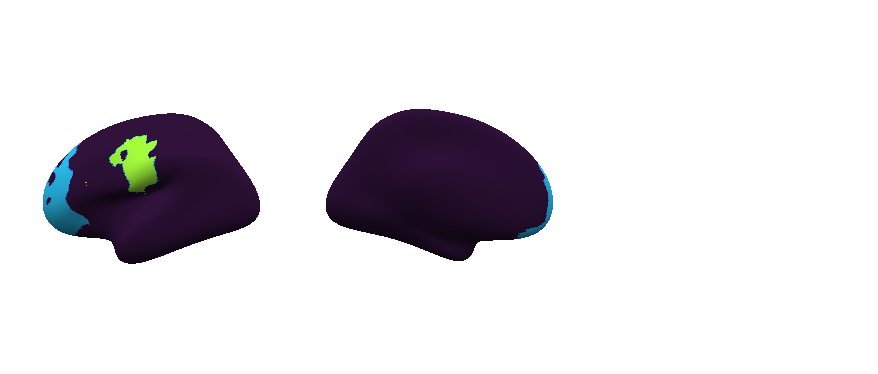

In [6]:
# look at one example
subject = 'MELD_H18_3T_FCD_0122'
# subject = 'MELD_H21_3T_FCD_0011'
subject = 'MELD_H4_3T_FCD_0014'
subj = MeldSubject(subject, cohort)
hemi = subj.get_lesion_hemisphere()
labels = subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:]
mask = (labels>0).astype(bool)
labels_clust = cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0)
msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],labels_clust, cmap='turbo', colorbar=False)

Text(0, 0.5, 'Number of patients')

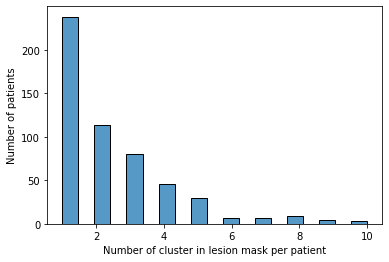

In [102]:
# plot cluster number in lesion mask 

sns.histplot(x='n_cluster', data=df)
plt.xlabel('Number of cluster in lesion mask per patient')
plt.ylabel('Number of patients')


number of cluster above 100:
12


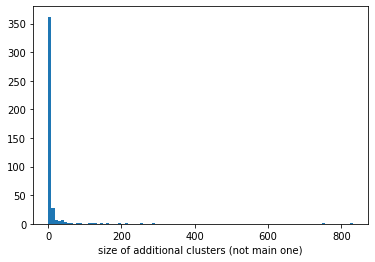

In [30]:
# size of clusters that are not the main one

df_side_cl = df[[f'size_cluster_{x}.0' for x in range(3,10)]]
size_side_cl = df_side_cl.values.flatten()
plt.hist(size_side_cl, bins=100)
plt.xlabel('size of additional clusters (not main one)')

print('number of cluster above 100:')
print((size_side_cl > 100).sum())



In [32]:
df_side_cl

,size_cluster_1,size_cluster_2,size_cluster_3,size_cluster_4,size_cluster_5,size_cluster_6,size_cluster_7,size_cluster_8,size_cluster_9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,233.0,5.0,14.0,5.0,3.0,2.0,1.0,1.0,NaN


MRI+ve lesion size, median [IQR]: 1710.0 [ 690.5  3736.25]
MRI-ve lesion size, median [IQR]: 1119.0 [ 638.5  3351.75]
U1 and p from Mann-Whitney 35548.0 0.038692713900400195
Z and p from Mann-Whitney -2.0674388290160013 0.03869282264140217


Text(0.5, 1.0, 'Mann-Whitney test: Z=-2.07, p=0.04')

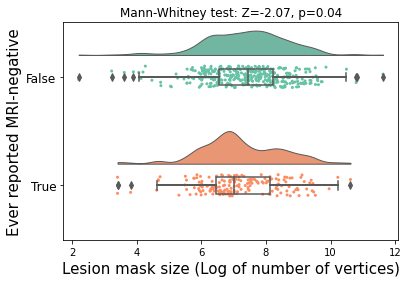

In [25]:
# plot biggest cluster size in MRI-negative vs MRI-positive

import scipy.stats as stats
from scipy.stats import norm

df['log_cluster'] = np.log(df['size_cluster_1.0'])
pt.RainCloud(x='log_cluster', y='MRI-negative',  data=df, bw= .2, cut=0, orient='horizontal',  scale="area", order=[0,1],
            width_viol=.6, jitter = 0.1, dodge=False)

plt.xlabel('Lesion mask size (Log of number of vertices)', fontsize=15)
plt.ylabel('Ever reported MRI-negative', fontsize=15)
plt.yticks([0, 1], ['False', 'True'], fontsize=12)

# get stats with Mann Whitney U as not parametric
x = df[df['MRI-negative']==0]['size_cluster_1.0'].values
y = df[df['MRI-negative']==1]['size_cluster_1.0'].values
print('MRI+ve lesion size, median [IQR]:', np.median(x), np.quantile(x,[0.25,0.75]))
print('MRI-ve lesion size, median [IQR]:', np.median(y), np.quantile(y,[0.25,0.75]))
U1, p = stats.mannwhitneyu(x, y)
print('U1 and p from Mann-Whitney', U1, p)
# compute back the z value
nx, ny = len(x), len(y)
U2 = nx*ny - U1
U = min(U1, U2)
N = nx + ny
z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
p = 2 * norm.cdf(z)  # use CDF to get p-value from smaller statistic
print('Z and p from Mann-Whitney', z, p)
plt.title(f'Mann-Whitney test: Z={round(z,2)}, p={round(p,2)}')




AttributeError: 'XAxis' object has no attribute 'get_xticks'

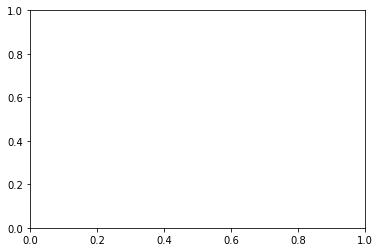

In [97]:
plt.gca().axes.xaxis.get_xticks()

0     1411
0     1131
0     3859
0     2293
0    27592
     ...  
0     3885
0     2380
0     2131
0     6299
0      779
Name: size_cluster_1.0, Length: 538, dtype: int64

In [78]:
plt.axes.get_xticklabels(minor=False, which=None)


AttributeError: 'function' object has no attribute 'get_xticklabels'